In [25]:
import numpy as np
import scipy as sp
import scipy.stats as stat
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, FloatSlider

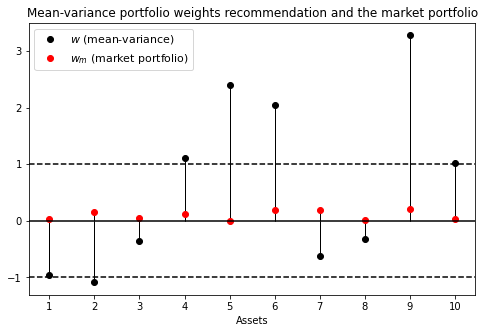

In [26]:
np.random.seed(12)

N = 10                                           # Number of assets
T = 200                                          # Sample size

# random market portfolio (sum is normalized to 1)
w_m = np.random.rand(N)
w_m = w_m / (w_m.sum())

# True risk premia and variance of excess return (constructed
# so that the Sharpe ratio is 1)
μ = (np.random.randn(N) + 5)  /100      # Mean excess return (risk premium)
S = np.random.randn(N, N)        # Random matrix for the covariance matrix
V = S @ S.T           # Turn the random matrix into symmetric psd
# Make sure that the Sharpe ratio is one
Σ = V * (w_m @ μ)**2 / (w_m @ V @ w_m)

# Risk aversion of market portfolio holder
δ = 1 / np.sqrt(w_m @ Σ @ w_m)

# Generate a sample of excess returns
excess_return = stat.multivariate_normal(μ, Σ)
sample = excess_return.rvs(T)

# Estimate μ and Σ
μ_est = sample.mean(0).reshape(N, 1)
Σ_est = np.cov(sample.T)

w = np.linalg.solve(δ * Σ_est, μ_est)

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Mean-variance portfolio weights recommendation and the market portfolio')
ax.plot(np.arange(N)+1, w, 'o', c='k', label='$w$ (mean-variance)')
ax.plot(np.arange(N)+1, w_m, 'o', c='r', label='$w_m$ (market portfolio)')
ax.vlines(np.arange(N)+1, 0, w, lw=1)
ax.vlines(np.arange(N)+1, 0, w_m, lw=1)
ax.axhline(0, c='k')
ax.axhline(-1, c='k', ls='--')
ax.axhline(1, c='k', ls='--')
ax.set_xlabel('Assets')
ax.xaxis.set_ticks(np.arange(1, N+1, 1))
plt.legend(numpoints=1, fontsize=11)
plt.show()

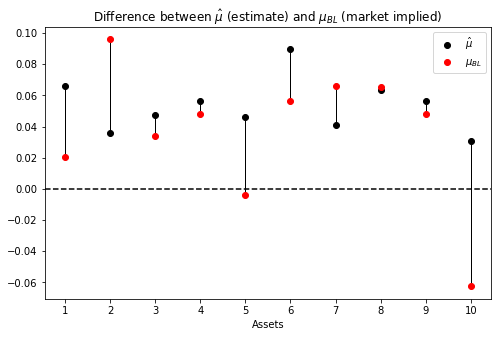

In [27]:
# Observed mean excess market return
r_m = w_m @ μ_est

# Estimated variance of the market portfolio
σ_m = w_m @ Σ_est @ w_m

# Sharpe-ratio
sr_m = r_m / np.sqrt(σ_m)

# Risk aversion of market portfolio holder
d_m = r_m / σ_m

# Derive "view" which would induce the market portfolio
μ_m = (d_m * Σ_est @ w_m).reshape(N, 1)

fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title(r'Difference between $\hat{\mu}$ (estimate) and $\mu_{BL}$ (market implied)')
ax.plot(np.arange(N)+1, μ_est, 'o', c='k', label='$\hat{\mu}$')
ax.plot(np.arange(N)+1, μ_m, 'o', c='r', label='$\mu_{BL}$')
ax.vlines(np.arange(N) + 1, μ_m, μ_est, lw=1)
ax.axhline(0, c='k', ls='--')
ax.set_xlabel('Assets')
ax.xaxis.set_ticks(np.arange(1, N+1, 1))
plt.legend(numpoints=1)
plt.show()

In [28]:
def black_litterman(λ, μ1, μ2, Σ1, Σ2):
    """
    This function calculates the Black-Litterman mixture
    mean excess return and covariance matrix
    """
    Σ1_inv = np.linalg.inv(Σ1)
    Σ2_inv = np.linalg.inv(Σ2)

    μ_tilde = np.linalg.solve(Σ1_inv + λ * Σ2_inv,
                              Σ1_inv @ μ1 + λ * Σ2_inv @ μ2)
    return μ_tilde

τ = 1
μ_tilde = black_litterman(1, μ_m, μ_est, Σ_est, τ * Σ_est)

# The Black-Litterman recommendation for the portfolio weights
w_tilde = np.linalg.solve(δ * Σ_est, μ_tilde)

τ_slider = FloatSlider(min=0.05, max=10, step=0.5, value=τ)

@interact(τ=τ_slider)
def BL_plot(τ):
    μ_tilde = black_litterman(1, μ_m, μ_est, Σ_est, τ * Σ_est)
    w_tilde = np.linalg.solve(δ * Σ_est, μ_tilde)

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].plot(np.arange(N)+1, μ_est, 'o', c='k',
               label=r'$\hat{\mu}$ (subj view)')
    ax[0].plot(np.arange(N)+1, μ_m, 'o', c='r',
               label=r'$\mu_{BL}$ (market)')
    ax[0].plot(np.arange(N)+1, μ_tilde, 'o', c='y',
               label=r'$\tilde{\mu}$ (mixture)')
    ax[0].vlines(np.arange(N)+1, μ_m, μ_est, lw=1)
    ax[0].axhline(0, c='k', ls='--')
    ax[0].set(xlim=(0, N+1), xlabel='Assets',
              title=r'Relationship between $\hat{\mu}$, $\mu_{BL}$, and  $ \tilde{\mu}$')
    ax[0].xaxis.set_ticks(np.arange(1, N+1, 1))
    ax[0].legend(numpoints=1)

    ax[1].set_title('Black-Litterman portfolio weight recommendation')
    ax[1].plot(np.arange(N)+1, w, 'o', c='k', label=r'$w$ (mean-variance)')
    ax[1].plot(np.arange(N)+1, w_m, 'o', c='r', label=r'$w_{m}$ (market, BL)')
    ax[1].plot(np.arange(N)+1, w_tilde, 'o', c='y',
               label=r'$\tilde{w}$ (mixture)')
    ax[1].vlines(np.arange(N)+1, 0, w, lw=1)
    ax[1].vlines(np.arange(N)+1, 0, w_m, lw=1)
    ax[1].axhline(0, c='k')
    ax[1].axhline(-1, c='k', ls='--')
    ax[1].axhline(1, c='k', ls='--')
    ax[1].set(xlim=(0, N+1), xlabel='Assets',
              title='Black-Litterman portfolio weight recommendation')
    ax[1].xaxis.set_ticks(np.arange(1, N+1, 1))
    ax[1].legend(numpoints=1)
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='τ', max=10.0, min=0.05, step=0.5), Output()), _dom_c…

In [29]:
np.random.seed(1987102)

N = 2                                           # Number of assets
T = 200                                         # Sample size
τ = 0.8

# Random market portfolio (sum is normalized to 1)
w_m = np.random.rand(N)
w_m = w_m / (w_m.sum())

μ = (np.random.randn(N) + 5) / 100
S = np.random.randn(N, N)
V = S @ S.T
Σ = V * (w_m @ μ)**2 / (w_m @ V @ w_m)

excess_return = stat.multivariate_normal(μ, Σ)
sample = excess_return.rvs(T)

μ_est = sample.mean(0).reshape(N, 1)
Σ_est = np.cov(sample.T)

σ_m = w_m @ Σ_est @ w_m
d_m = (w_m @ μ_est) / σ_m
μ_m = (d_m * Σ_est @ w_m).reshape(N, 1)

N_r1, N_r2 = 100, 100
r1 = np.linspace(-0.04, .1, N_r1)
r2 = np.linspace(-0.02, .15, N_r2)

λ_grid = np.linspace(.001, 20, 100)
curve = np.asarray([black_litterman(λ, μ_m, μ_est, Σ_est,
                                    τ * Σ_est).flatten() for λ in λ_grid])

λ_slider = FloatSlider(min=.1, max=7, step=.5, value=1)

@interact(λ=λ_slider)
def decolletage(λ):
    dist_r_BL = stat.multivariate_normal(μ_m.squeeze(), Σ_est)
    dist_r_hat = stat.multivariate_normal(μ_est.squeeze(), τ * Σ_est)

    X, Y = np.meshgrid(r1, r2)
    Z_BL = np.zeros((N_r1, N_r2))
    Z_hat = np.zeros((N_r1, N_r2))

    for i in range(N_r1):
        for j in range(N_r2):
            Z_BL[i, j] = dist_r_BL.pdf(np.hstack([X[i, j], Y[i, j]]))
            Z_hat[i, j] = dist_r_hat.pdf(np.hstack([X[i, j], Y[i, j]]))

    μ_tilde = black_litterman(λ, μ_m, μ_est, Σ_est, τ * Σ_est).flatten()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.contourf(X, Y, Z_hat, cmap='viridis', alpha =.4)
    ax.contourf(X, Y, Z_BL, cmap='viridis', alpha =.4)
    ax.contour(X, Y, Z_BL, [dist_r_BL.pdf(μ_tilde)], cmap='viridis', alpha=.9)
    ax.contour(X, Y, Z_hat, [dist_r_hat.pdf(μ_tilde)], cmap='viridis', alpha=.9)
    ax.scatter(μ_est[0], μ_est[1])
    ax.scatter(μ_m[0], μ_m[1])
    ax.scatter(μ_tilde[0], μ_tilde[1], c='k', s=20*3)

    ax.plot(curve[:, 0], curve[:, 1], c='k')
    ax.axhline(0, c='k', alpha=.8)
    ax.axvline(0, c='k', alpha=.8)
    ax.set_xlabel(r'Excess return on the first asset, $r_{e, 1}$')
    ax.set_ylabel(r'Excess return on the second asset, $r_{e, 2}$')
    ax.text(μ_est[0] + 0.003, μ_est[1], r'$\hat{\mu}$')
    ax.text(μ_m[0] + 0.003, μ_m[1] + 0.005, r'$\mu_{BL}$')
    plt.show()

interactive(children=(FloatSlider(value=1.0, description='λ', max=7.0, min=0.1, step=0.5), Output()), _dom_cla…

In [30]:
λ_grid = np.linspace(.001, 20000, 1000)
curve = np.asarray([black_litterman(λ, μ_m, μ_est, Σ_est,
                                    τ * np.eye(N)).flatten() for λ in λ_grid])

λ_slider = FloatSlider(min=5, max=1500, step=100, value=200)

@interact(λ=λ_slider)
def decolletage(λ):
    dist_r_BL = stat.multivariate_normal(μ_m.squeeze(), Σ_est)
    dist_r_hat = stat.multivariate_normal(μ_est.squeeze(), τ * np.eye(N))

    X, Y = np.meshgrid(r1, r2)
    Z_BL = np.zeros((N_r1, N_r2))
    Z_hat = np.zeros((N_r1, N_r2))

    for i in range(N_r1):
        for j in range(N_r2):
            Z_BL[i, j] = dist_r_BL.pdf(np.hstack([X[i, j], Y[i, j]]))
            Z_hat[i, j] = dist_r_hat.pdf(np.hstack([X[i, j], Y[i, j]]))

    μ_tilde = black_litterman(λ, μ_m, μ_est, Σ_est, τ * np.eye(N)).flatten()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.contourf(X, Y, Z_hat, cmap='viridis', alpha=.4)
    ax.contourf(X, Y, Z_BL, cmap='viridis', alpha=.4)
    ax.contour(X, Y, Z_BL, [dist_r_BL.pdf(μ_tilde)], cmap='viridis', alpha=.9)
    ax.contour(X, Y, Z_hat, [dist_r_hat.pdf(μ_tilde)], cmap='viridis', alpha=.9)
    ax.scatter(μ_est[0], μ_est[1])
    ax.scatter(μ_m[0], μ_m[1])

    ax.scatter(μ_tilde[0], μ_tilde[1], c='k', s=20*3)

    ax.plot(curve[:, 0], curve[:, 1], c='k')
    ax.axhline(0, c='k', alpha=.8)
    ax.axvline(0, c='k', alpha=.8)
    ax.set_xlabel(r'Excess return on the first asset, $r_{e, 1}$')
    ax.set_ylabel(r'Excess return on the second asset, $r_{e, 2}$')
    ax.text(μ_est[0] + 0.003, μ_est[1], r'$\hat{\mu}$')
    ax.text(μ_m[0] + 0.003, μ_m[1] + 0.005, r'$\mu_{BL}$')
    plt.show()

interactive(children=(FloatSlider(value=200.0, description='λ', max=1500.0, min=5.0, step=100.0), Output()), _…

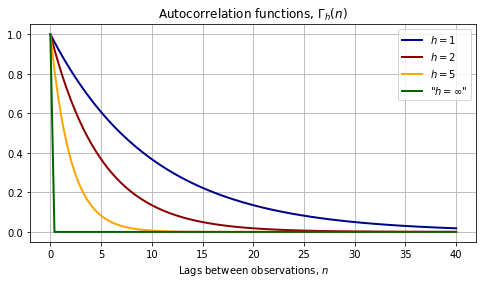

In [31]:
μ = .0
κ = .1
σ = .5
var_uncond = σ**2 / (2 * κ)

n_grid = np.linspace(0, 40, 100)
autocorr_h1 = np.exp(-κ * n_grid * 1)
autocorr_h2 = np.exp(-κ * n_grid * 2)
autocorr_h5 = np.exp(-κ * n_grid * 5)
autocorr_h1000 = np.exp(-κ * n_grid * 1e8)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(n_grid, autocorr_h1, label=r'$h=1$', c='darkblue', lw=2)
ax.plot(n_grid, autocorr_h2, label=r'$h=2$', c='darkred', lw=2)
ax.plot(n_grid, autocorr_h5, label=r'$h=5$', c='orange', lw=2)
ax.plot(n_grid, autocorr_h1000, label=r'"$h=\infty$"', c='darkgreen', lw=2)
ax.legend()
ax.grid()
ax.set(title=r'Autocorrelation functions, $\Gamma_h(n)$',
       xlabel=r'Lags between observations, $n$')
plt.show()

In [32]:
def sample_generator(h, N, M):
    ϕ = (1 - np.exp(-κ * h)) * μ
    ρ = np.exp(-κ * h)
    s = σ**2 * (1 - np.exp(-2 * κ * h)) / (2 * κ)

    mean_uncond = μ
    std_uncond = np.sqrt(σ**2 / (2 * κ))

    ε_path = stat.norm(0, np.sqrt(s)).rvs((M, N))

    y_path = np.zeros((M, N + 1))
    y_path[:, 0] = stat.norm(mean_uncond, std_uncond).rvs(M)

    for i in range(N):
        y_path[:, i + 1] = ϕ + ρ * y_path[:, i] + ε_path[:, i]

    return y_path

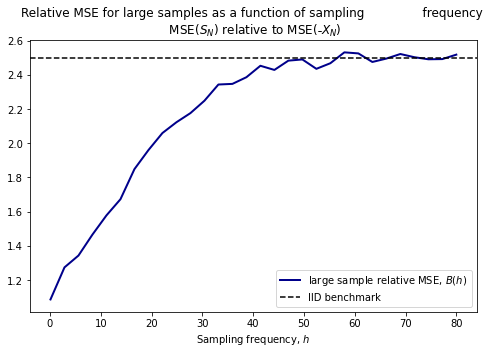

In [33]:
# Generate large sample for different frequencies
N_app, M_app = 1000, 30000        # Sample size, number of simulations
h_grid = np.linspace(.1, 80, 30)

var_est_store = []
mean_est_store = []
labels = []

for h in h_grid:
    labels.append(h)
    sample = sample_generator(h, N_app, M_app)
    mean_est_store.append(np.mean(sample, 1))
    var_est_store.append(np.var(sample, 1))

var_est_store = np.array(var_est_store)
mean_est_store = np.array(mean_est_store)

# Save mse of estimators
mse_mean = np.var(mean_est_store, 1) + (np.mean(mean_est_store, 1) - μ)**2
mse_var = np.var(var_est_store, 1) \
          + (np.mean(var_est_store, 1) - var_uncond)**2

benchmark_rate = 2 * var_uncond       # IID case

# Relative MSE for large samples
rate_h = mse_var / mse_mean

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(h_grid, rate_h, c='darkblue', lw=2,
        label=r'large sample relative MSE, $B(h)$')
ax.axhline(benchmark_rate, c='k', ls='--', label=r'IID benchmark')
ax.set_title('Relative MSE for large samples as a function of sampling \
              frequency \n MSE($S_N$) relative to MSE($\\bar X_N$)')
ax.set_xlabel('Sampling frequency, $h$')
ax.legend()
plt.show()
